# Evaluating the Performance of MiDaS on Drone Data
---

Here you can configure the script to work with your data.

In [55]:
bag_file_name = 'test3.bag'

topic_cam1 = '/d455/infra1/image_rect_raw'
topic_cam2 = '/d455/infra2/image_rect_raw'

# running MiDaS
input_path = 'input'
output_path = 'output'
model_path = 'weights/dpt_beit_large_512.pt'
model_type = 'dpt_beit_large_512'
optimize=False
side=False
height=None
square=False
grayscale=True # Realsense output is grayscale

## Getting drone footage

In [56]:
import os
import rosbag
import bag2data as b2d
import cv2
import matplotlib.pyplot as plt
import numpy as np
import run

bag = rosbag.Bag(os.path.join('drone_data', bag_file_name))

# get data from rosbag
image_data_infra1_ros = b2d.getImageData(bag, topic_cam1)
image_data_infra2_ros = b2d.getImageData(bag, topic_cam2)

# transform data into list of numpy arrays/matrices
image_data_infra1_np = b2d.ros_IMG_2numpy(image_data_infra1_ros)
image_data_infra2_np = b2d.ros_IMG_2numpy(image_data_infra2_ros)

print("The bags contain", len(image_data_infra1_np), "and", len(image_data_infra2_np), "Frames.")

The bags contain 843 and 840 Frames.


## Estimating depth in drone footage

In [57]:
# run MiDaS on data from rosbag
run.run(input_path, output_path, model_path, model_type, optimize, side, height, square, grayscale)

Initialize
Device: cpu


c:\Users\User\.conda\envs\midas-performance-py310\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Model loaded, number of parameters = 345M
Start processing
  Processing input\0.png (1/3)
    Input resized to 896x512 before entering the encoder
  Processing input\1.png (2/3)
    Input resized to 896x512 before entering the encoder
  Processing input\2.png (3/3)
    Input resized to 896x512 before entering the encoder
Finished


In [65]:
folder = 'output'
depth_estimate_images = b2d.load_images_from_folder(folder)

## Getting "real" depth from Intel Realsense

In [66]:
bag = rosbag.Bag(os.path.join('drone_data', bag_file_name))


depth_data_ros = b2d.getDepthData(bag, '/d455/depth/image_rect_raw')

depth_measurement_images = b2d.ros_DEPTH_2numpy(depth_data_ros)

## Comparing estimation to "ground truth"

In [99]:
'''
We have:
    - depth_estimate_images         [0-255]
    - depth_measurement_images      [0-65535] in mm // TODO: Check if actually mm (could also be value set in camera-options)
'''
max_depth = depth_measurement_images[0].max()
difference_pic_zero = depth_estimate_images[0]/255 + depth_measurement_images[0]/max_depth


## Results

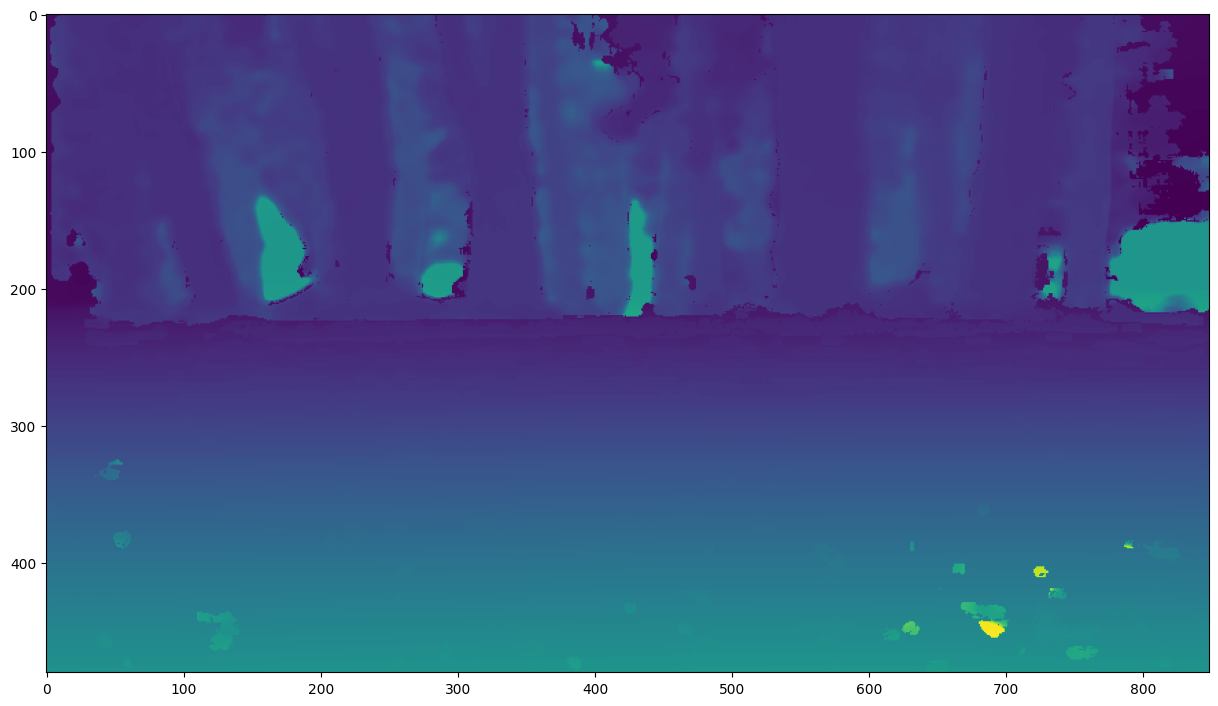

In [100]:
fig = plt.figure(figsize =(15, 15))
plt.imshow(difference_pic_zero) # cmap='gray'
plt.show()

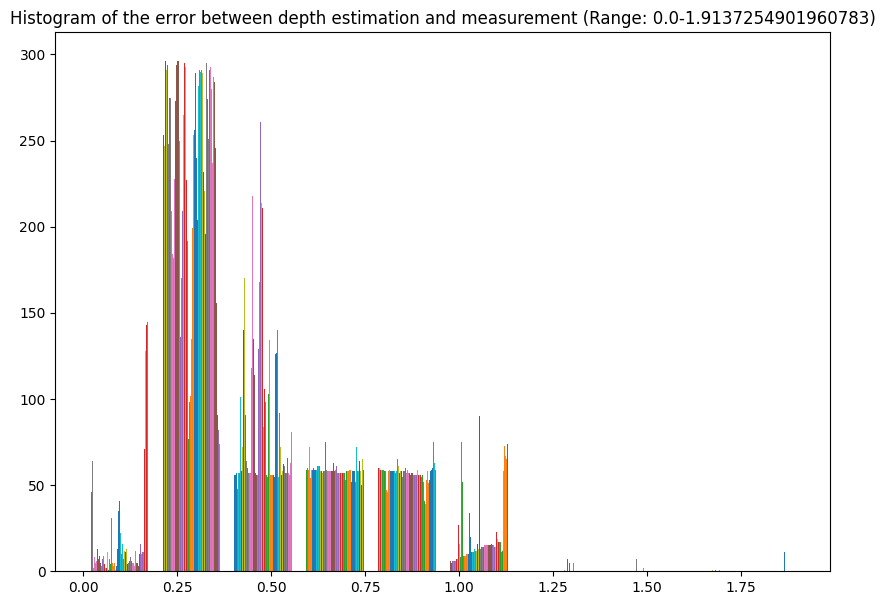

In [69]:
fig = plt.figure(figsize =(10, 7))

plt.hist(difference_pic_zero) 

min_error = difference_pic_zero.min()
max_error = difference_pic_zero.max()
text="Histogram of the error between depth estimation and measurement (Range: " + str(min_error) + "-" + str(max_error) + ")"

plt.title(text)
plt.show()

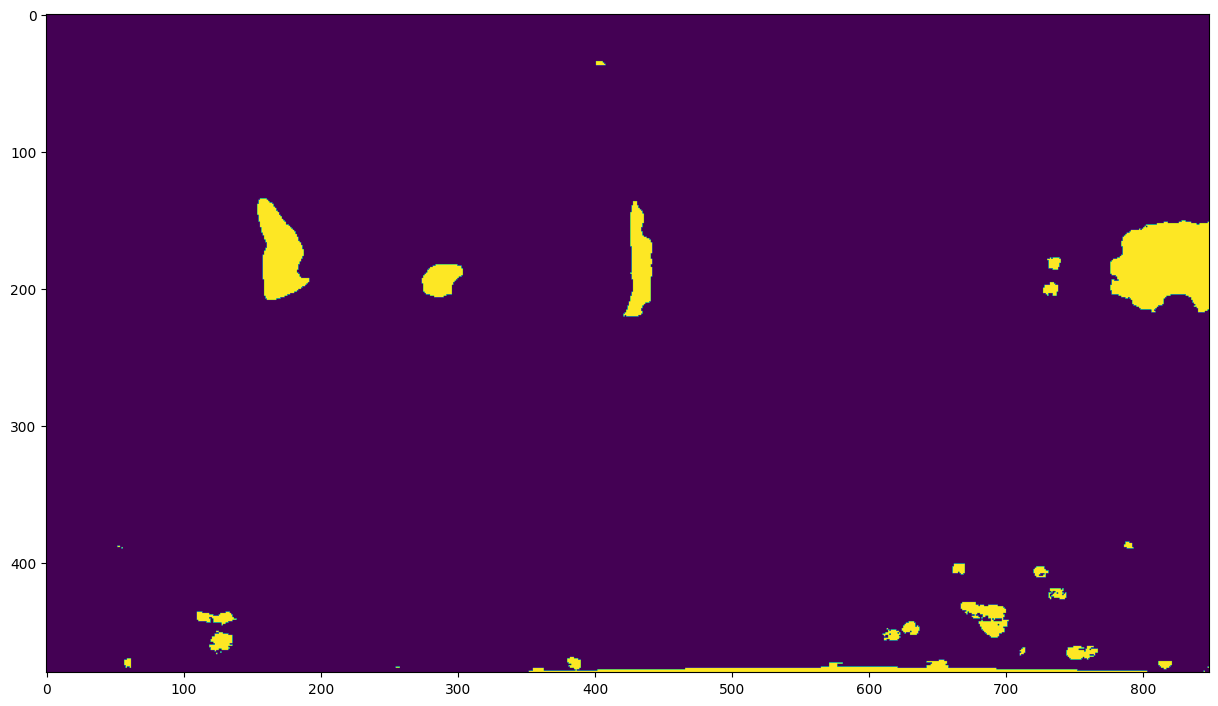

In [101]:
error_matrix = difference_pic_zero

# Find the unique values in the array
unique_values = np.unique(error_matrix)

# Sort the unique values in descending order and get the 10 largest ones
largest_values = np.sort(unique_values)[::-1][:1000]

# Create a Boolean mask that sets the largest 10 unique values to True
mask = np.isin(error_matrix, largest_values)

difference_pic_zero_extremes = np.zeros_like(error_matrix)
difference_pic_zero_extremes[mask] = 255


fig = plt.figure(figsize =(15, 15))
plt.imshow(difference_pic_zero_extremes)
plt.show()

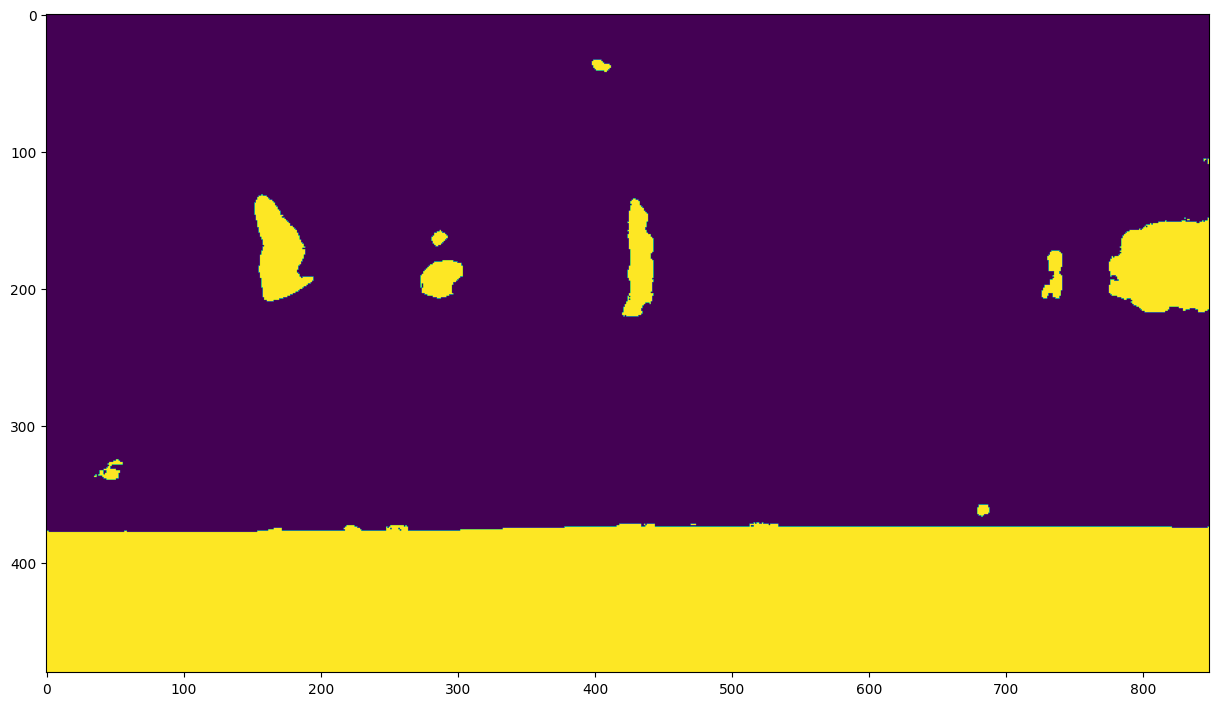

In [128]:
error_matrix = difference_pic_zero

# Find the unique values in the array
unique_values = np.unique(error_matrix)

# Sort the unique values in descending order and get the 10 largest ones
largest_values = np.sort(unique_values)[::-1][:3500]

# Create a Boolean mask that sets the largest 10 unique values to True
mask = np.isin(error_matrix, largest_values)

difference_pic_zero_extremes = np.zeros_like(error_matrix)
difference_pic_zero_extremes[mask] = 255


fig = plt.figure(figsize =(15, 15))
plt.imshow(difference_pic_zero_extremes)
plt.show()

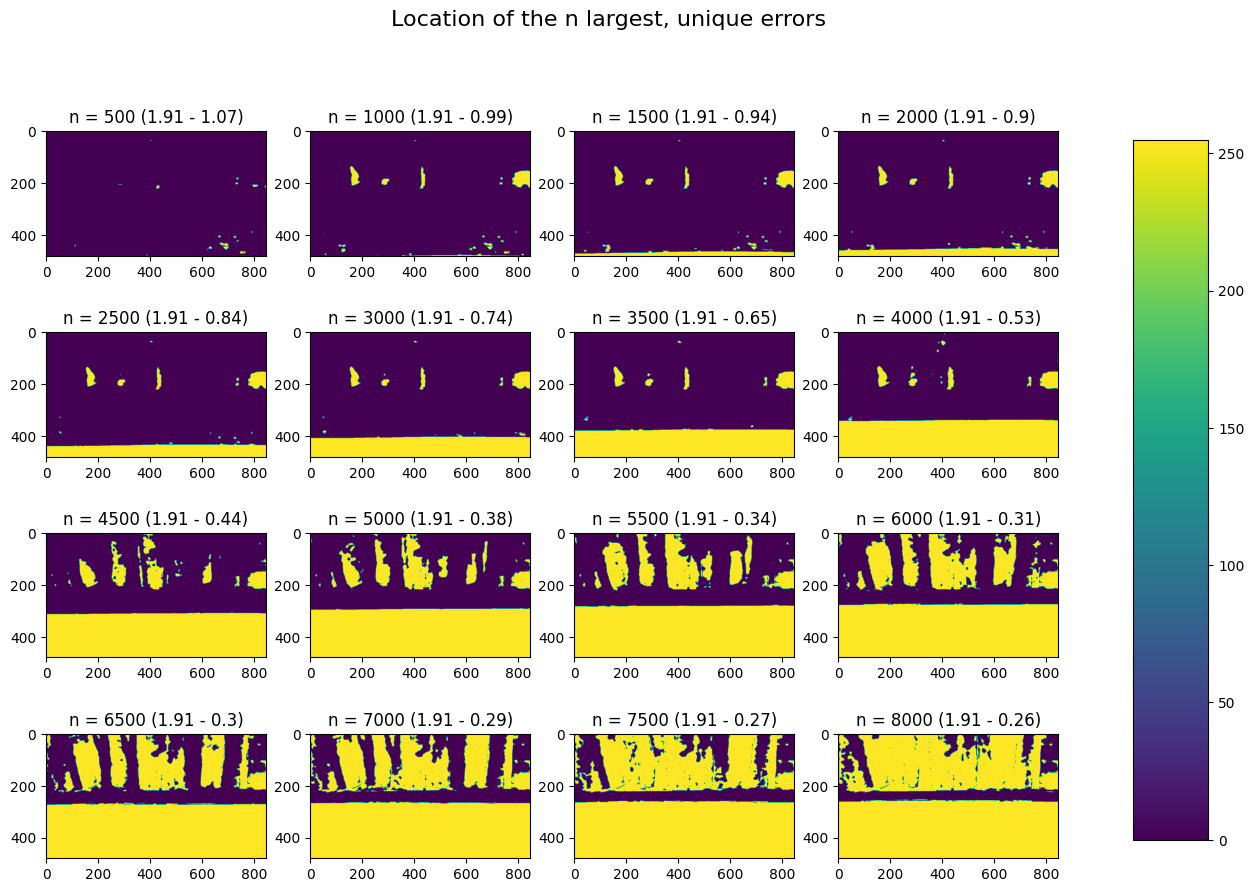

In [131]:
# fig = plt.figure(figsize =(15, 15))

fig, axes = plt.subplots(nrows=4, ncols=4, figsize =(15, 10))
for idx, ax in enumerate(axes.flat):

    error_matrix = difference_pic_zero

    # Find the unique values in the array
    unique_values = np.unique(error_matrix)

    # Sort the unique values in descending order and get the 'largest_amount' largest ones
    largest_amount = 500*(idx+1)
    largest_values = np.sort(unique_values)[::-1][:(largest_amount)]

    # Create a Boolean mask that sets the largest 10 unique values to True
    mask = np.isin(error_matrix, largest_values)

    difference_pic_zero_extremes = np.zeros_like(error_matrix)
    difference_pic_zero_extremes[mask] = 255

    # fig = plt.figure(figsize =(15, 15))
    roundingval = 2
    text = "n = "+str(largest_amount) + " (" + str(round(largest_values[0],roundingval)) + " - " +str(round(largest_values[-1],roundingval)) + ")"
    ax.set_title(text)   
    
    im = ax.imshow(difference_pic_zero_extremes, vmin=0, vmax=255) #np.random.random((10,10))


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.suptitle('Location of the n largest, unique errors', fontsize=16)
plt.show()
# plt.colorbar(label="error", orientation="horizontal")


We can see the following:
* *HIGH MAGNITUDE ERRORS*: Very <ins>small artifacts</ins> in various places without obvious pattern 
* *MEDIUM MAGNITUDE ERRORS*: Larger areas of <ins>lower accuracy</ins> in the <ins>background</ins>
* *LOW MAGNITUDE ERRORS*: Tendency of errors in the <ins>foreground</ins>